20240529 코드실습

In [1]:
# 사용할 라이브러리 버전 둘러보기

import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

2.0.3
4.3.0
0.5.2
1.4.1.post1


### **Light GBM** 파라미터 설명과 코드실습

**개념**: 트리 기준 분할이 아니라, 리프 기준 분할이다. 즉, 트리의 균형을 맞추지 않고 최대 손실 값을 갖는 리프 노드를 지속적으로 분할해 깊고 비대칭적인 트리를 생성한다. 그렇게 하면 트리 기준 분할 방식에 비해 예측 오류 손실을 최소화할 수 있다.   

**장점**  
- 학습시간이 짧다. 
- 메모리 사용량이 상대적으로 적다.   

**단점**
- 적은 데이터셋에서는 오버피팅이 발생

**사용되는 주요 파라미터**  
- num_iterations: 반복 수행하려는 트리의 개수
- objective: 수치면 regression 이진분류면 binary
- learning_rate: 학습률
- max_depth: 트리의 깊이. 
- min_data_in_leaf: 한 리프의 최소 데이터 개수 (디폴트 20)
- num_leaves: 하나의 트리가 가질 수 있는 최대 리프의 개수 (디폴트 30)
- boosting: 부스팅 방법. gbdt? rf (랜덤 포레스트)? 
  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
## 먼저 데이터 확인부터 하기 

print(train.shape, test.shape)

(15035, 21) (6555, 20)


In [4]:
set(train.columns) - set(test.columns)  #price는 train만 있고, test 엔 없다. 그리고 20개의 feature로 되어 있음 

{'price'}

In [5]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

***목표***
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [6]:
##각 변수에 대해 인사이트 얻기

print(train.info()) #date 혼자면 object이고, null값은 없고, 모두 15035 개의 값을 가지는 것을 알 수 있음 
print(test.info()) #date 혼자면 object이고, null값은 없고, 모두 6555 개의 값을 가지는 것을 알 수 있음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
print(train['date'].head(),test['date'].head())

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
Name: date, dtype: object 0    20140512T000000
1    20150312T000000
2    20150124T000000
3    20141205T000000
4    20140514T000000
Name: date, dtype: object


In [8]:
new_date_train = train['date'].apply(lambda i: i[:6]).astype(int)
#new_date_train
new_date_test = test['date'].apply(lambda i: i[:6]).astype(int)

train['date'] = new_date_train
test['date'] = new_date_test

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15208,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1,15209,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
2,15210,201501,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
3,15211,201412,2,1.00,1200,9850,1.0,0,0,4,7,1200,0,1921,0,98002,47.3089,-122.210,1060,5095
4,15212,201405,4,1.75,1620,4980,1.0,0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,1400,4980


In [10]:
# sqft_living15랑 sqft_living이랑 다른 게 몇개나 있나?
# 일단 데이터를 합쳐서 살펴보자. price는 일단 빼놓자 안그러면 concat 안되니까..

price = train['price']
del train['price']
data = pd.concat([train, test], axis=0)

In [11]:
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,21758,201410,4,2.75,2770,3852,2.0,0,0,3,8,2770,0,2014,0,98178,47.5001,-122.232,1810,5641
6551,21759,201504,3,2.25,1190,1200,3.0,0,0,3,8,1190,0,2008,0,98103,47.6542,-122.346,1180,1224
6552,21760,201410,5,3.75,4470,8088,2.0,0,0,3,11,4470,0,2008,0,98004,47.6321,-122.200,2780,8964
6553,21761,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230


In [12]:
different_values = data[data['sqft_living15'] != data['sqft_living']]
len(different_values)  #헉 넘 많군,,,,,

19007

In [13]:
#  sqft 로 시작하는 변수들 feature 엔지니어링을 할까? => 그러나 이것은 단순히 선형회귀가 아님... 그냥 두자!

print(data['condition'].unique())  #명목
print(data['waterfront'].unique()) #명목
print(data['view'].unique()) #명목


[3 4 5 2 1]
[0 1]
[0 3 4 2 1]


In [14]:
# 원핫인코딩
dummy_data = pd.get_dummies(data, columns = ['condition', 'waterfront', 'view'])
dummy_data
data = dummy_data

In [15]:
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,...,condition_3,condition_4,condition_5,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4
0,0,201410,3,1.00,1180,5650,1.0,7,1180,0,...,True,False,False,True,False,True,False,False,False,False
1,1,201502,2,1.00,770,10000,1.0,6,770,0,...,True,False,False,True,False,True,False,False,False,False
2,2,201502,3,2.00,1680,8080,1.0,8,1680,0,...,True,False,False,True,False,True,False,False,False,False
3,3,201406,3,2.25,1715,6819,2.0,7,1715,0,...,True,False,False,True,False,True,False,False,False,False
4,4,201501,3,1.50,1060,9711,1.0,7,1060,0,...,True,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,21758,201410,4,2.75,2770,3852,2.0,8,2770,0,...,True,False,False,True,False,True,False,False,False,False
6551,21759,201504,3,2.25,1190,1200,3.0,8,1190,0,...,True,False,False,True,False,True,False,False,False,False
6552,21760,201410,5,3.75,4470,8088,2.0,11,4470,0,...,True,False,False,True,False,True,False,False,False,False
6553,21761,201501,3,2.00,1490,1126,3.0,8,1490,0,...,True,False,False,True,False,True,False,False,False,False


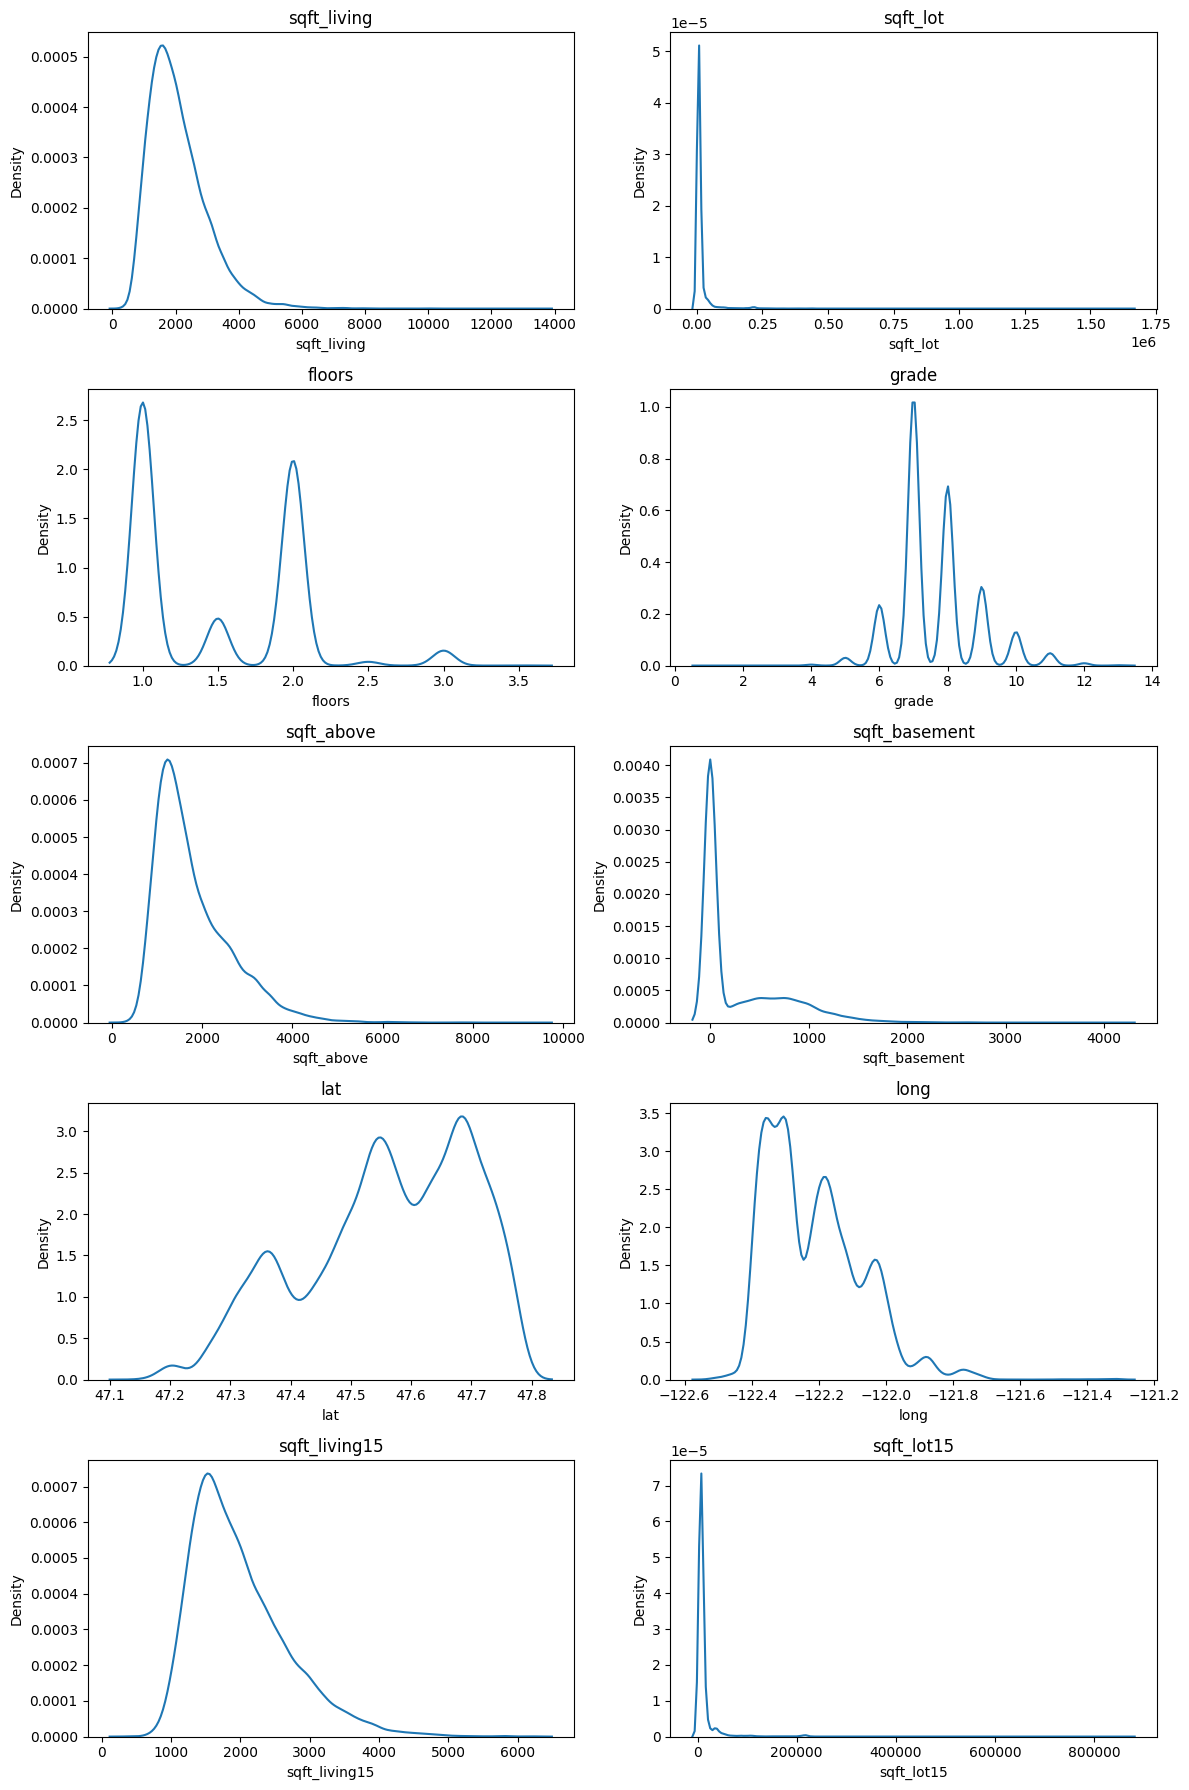

In [16]:
#이제 연속변수들 분포 확인할시간

columns = ['sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
for i, column in enumerate(columns):
    sns.kdeplot(data[column], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(column)

plt.tight_layout()
plt.show()

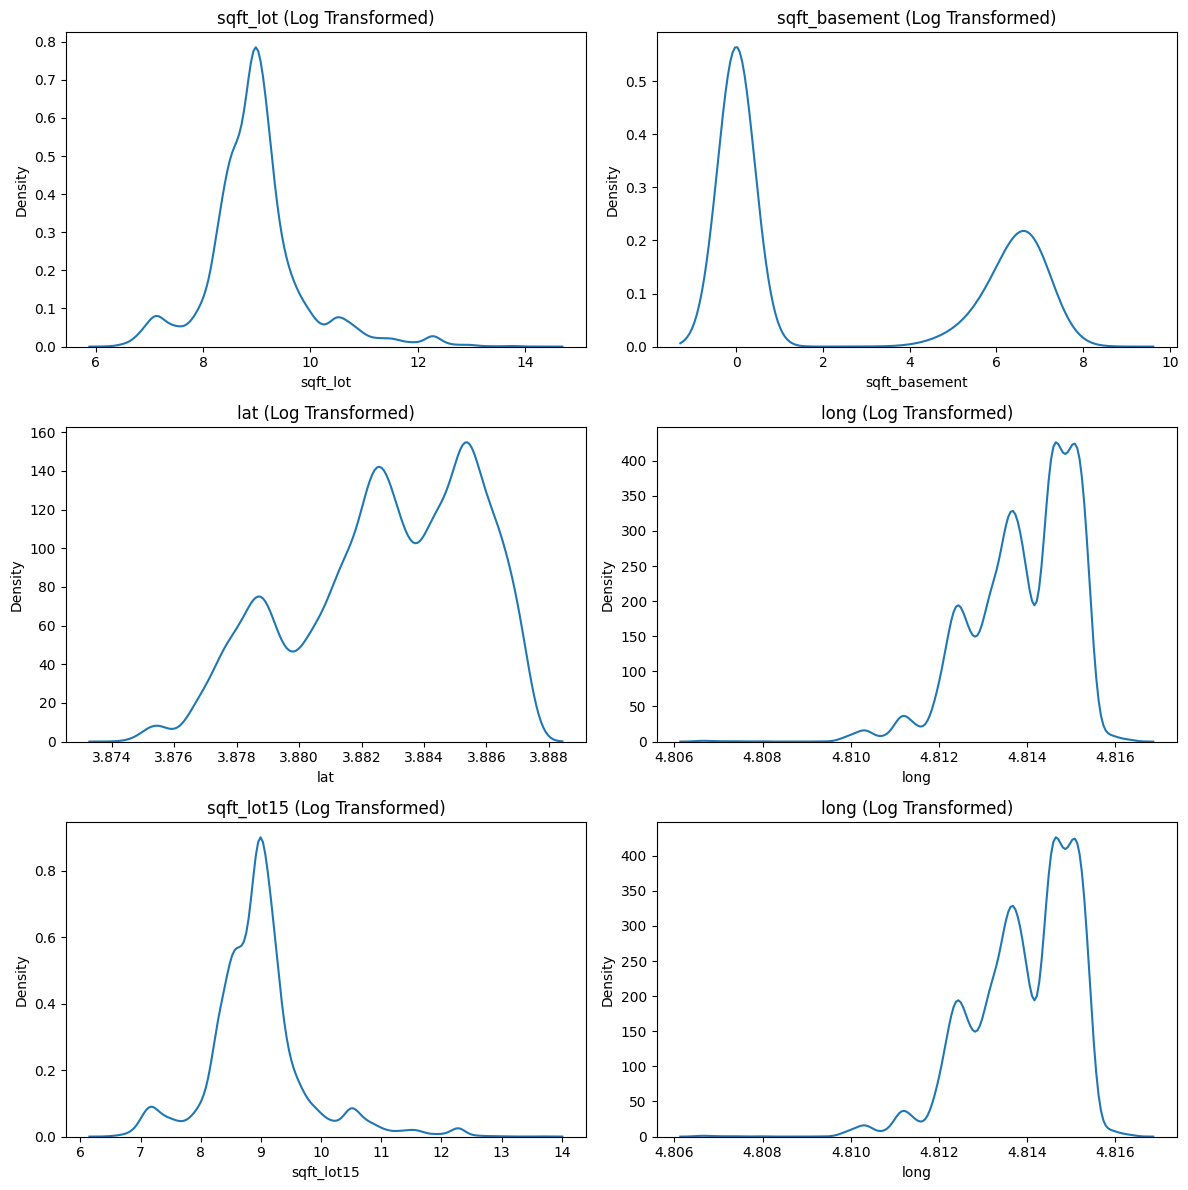

In [17]:
#치우친 변수들['sqft_lot', 'sqft_basement', 'lat', 'long', 'sqft_lot15'] 로그변환
# 로그 변환 수행
import numpy as np

# 데이터 복사
data_log_transformed = data.copy()

# 로그 변환할 변수들!!!!
columns_to_log_transform = ['sqft_lot', 'sqft_basement', 'lat', 'long', 'sqft_lot15']

# 음수 값을 양수로 변환 후 로그 변환 수행 (왜냐하면 long값은 다 음수라서 log변환이 안먹힘)
for column in columns_to_log_transform:
    if (data_log_transformed[column] < 0).any():
        data_log_transformed[column] = data_log_transformed[column].abs()

data_log_transformed[columns_to_log_transform] = np.log1p(data_log_transformed[columns_to_log_transform])

# 로그 변환된 데이터 분포 시각화
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for i, column in enumerate(columns_to_log_transform):
    sns.kdeplot(data_log_transformed[column], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(column + ' (Log Transformed)')

sns.kdeplot(data_log_transformed['long'], ax=axes[2, 1])
axes[2, 1].set_title('long (Log Transformed)')
plt.tight_layout()
plt.show()


In [18]:
#되었으니 이제 다시 안녕........

len(train)
data_log_transformed


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,...,condition_3,condition_4,condition_5,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4
0,0,201410,3,1.00,1180,8.639588,1.0,7,1180,0.0,...,True,False,False,True,False,True,False,False,False,False
1,1,201502,2,1.00,770,9.210440,1.0,6,770,0.0,...,True,False,False,True,False,True,False,False,False,False
2,2,201502,3,2.00,1680,8.997271,1.0,8,1680,0.0,...,True,False,False,True,False,True,False,False,False,False
3,3,201406,3,2.25,1715,8.827615,2.0,7,1715,0.0,...,True,False,False,True,False,True,False,False,False,False
4,4,201501,3,1.50,1060,9.181118,1.0,7,1060,0.0,...,True,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,21758,201410,4,2.75,2770,8.256607,2.0,8,2770,0.0,...,True,False,False,True,False,True,False,False,False,False
6551,21759,201504,3,2.25,1190,7.090910,3.0,8,1190,0.0,...,True,False,False,True,False,True,False,False,False,False
6552,21760,201410,5,3.75,4470,8.998260,2.0,11,4470,0.0,...,True,False,False,True,False,True,False,False,False,False
6553,21761,201501,3,2.00,1490,7.027315,3.0,8,1490,0.0,...,True,False,False,True,False,True,False,False,False,False


In [19]:
train_data = data_log_transformed.iloc[:len(train)]
test_data = data_log_transformed.iloc[len(train):]

In [20]:
print(len(train))
print(len(test))

15035
6555


In [21]:
print(train_data.info(), test_data.info())

del train_data['id']
del test_data['id']

<class 'pandas.core.frame.DataFrame'>
Index: 15035 entries, 0 to 15034
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int32  
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  float64
 6   floors         15035 non-null  float64
 7   grade          15035 non-null  int64  
 8   sqft_above     15035 non-null  int64  
 9   sqft_basement  15035 non-null  float64
 10  yr_built       15035 non-null  int64  
 11  yr_renovated   15035 non-null  int64  
 12  zipcode        15035 non-null  int64  
 13  lat            15035 non-null  float64
 14  long           15035 non-null  float64
 15  sqft_living15  15035 non-null  int64  
 16  sqft_lot15     15035 non-null  float64
 17  condition_1    15035 non-null  bool   
 18  condition_2

In [22]:
print(train_data.info(), test_data.info())  # 잘 없어진 것 확인 

<class 'pandas.core.frame.DataFrame'>
Index: 15035 entries, 0 to 15034
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   grade          15035 non-null  int64  
 7   sqft_above     15035 non-null  int64  
 8   sqft_basement  15035 non-null  float64
 9   yr_built       15035 non-null  int64  
 10  yr_renovated   15035 non-null  int64  
 11  zipcode        15035 non-null  int64  
 12  lat            15035 non-null  float64
 13  long           15035 non-null  float64
 14  sqft_living15  15035 non-null  int64  
 15  sqft_lot15     15035 non-null  float64
 16  condition_1    15035 non-null  bool   
 17  condition_2    15035 non-null  bool   
 18  condition_3

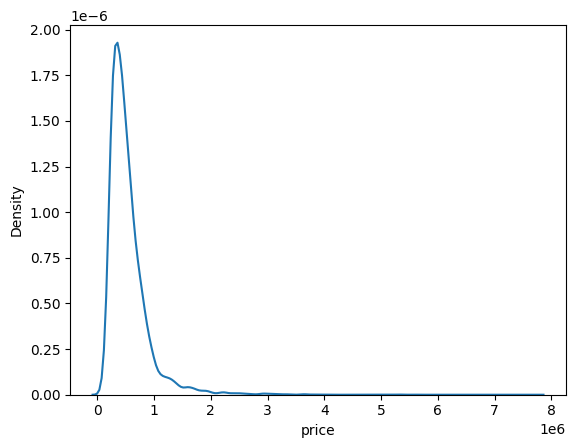

In [23]:
sns.kdeplot(price)  #price도 일단 log변환을..

price = np.log1p(price)


<Axes: xlabel='price', ylabel='Density'>

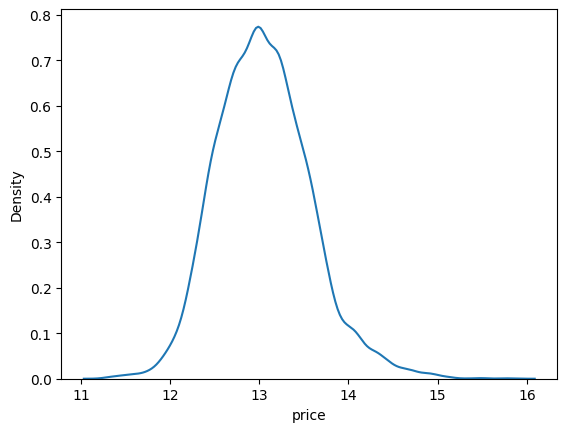

In [24]:
sns.kdeplot(price)  #good!

***목표***
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

In [26]:
gboost = GradientBoostingRegressor(random_state=2024)
xgboost = xgb.XGBRegressor(random_state=2024)
lightgbm = lgb.LGBMRegressor(random_state=2024)
rf = RandomForestRegressor(random_state=2024)

models = [gboost, xgboost, lightgbm, rf]


In [60]:
#평가지표는 rmse

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [59]:
#학습 모델 함수 만들기

def get_scores(models, train_data, price):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_data, price,test_size=0.3, random_state=2024)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse_result = rmse(y_test, y_pred)
        df[model_name] = rmse_result
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return df

get_scores(models, train_data, price) 

NameError: name 'mean_squared_error' is not defined

In [29]:
# 하이퍼 파라미터
from sklearn.model_selection import GridSearchCV

In [44]:
#각각에 대해 하이퍼파라미터 먼저 지정해보기 

param_grids = {
    'GradientBoostingRegressor': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.3],
        'max_depth': [3,4]
    },
    'XGBRegressor': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.3],
        'max_depth': [3, 4]
    },
    'LGBMRegressor': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.3],
        'num_leaves': [31, 50]
    },
    'RandomForestRegressor': {
        'n_estimators': [100],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}

In [45]:
def get_best_models(models, param_grids, X_train, y_train):
    best_models = {}
    for model in models:
        model_name = model.__class__.__name__
        print(f"Processing model: {model_name}")
        
        # 매개변수 그리드가 있는지 확인
        if model_name not in param_grids:
            raise ValueError(f"No parameter grid found for {model_name}")

        param_grid = param_grids[model_name]
        print(f"Parameter grid for {model_name}: {param_grid}")
        
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=1)
        grid_search.fit(X_train, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        
    return best_models

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_data, price, test_size=0.3, random_state=2024)
best_models = get_best_models(models, param_grids, X_train, y_train)

Processing model: GradientBoostingRegressor
Parameter grid for GradientBoostingRegressor: {'n_estimators': [100], 'learning_rate': [0.1, 0.3], 'max_depth': [3, 4]}
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
Processing model: XGBRegressor
Parameter grid for XGBRegressor: {'n_estimators': [100], 'learning_rate': [0.1, 0.3], 'max_depth': [3, 4]}
Best parameters for XGBRegressor: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
Processing model: LGBMRegressor
Parameter grid for LGBMRegressor: {'n_estimators': [100], 'learning_rate': [0.1, 0.3], 'num_leaves': [31, 50]}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8419, number of used features: 27
[LightGBM] [Info] Start training from score 13.048602
[LightGBM] [

- Best parameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
- Best parameters for XGBRegressor: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
- Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 50}
- Best parameters for RandomForestRegressor: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [61]:
#이제 평가식 만들기
from sklearn.metrics import mean_squared_error
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

In [54]:
#가장 좋은 모델들 모아놓음

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

best_models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.3, max_depth=4, n_estimators=100, random_state=2024),
    'XGBRegressor': xgb.XGBRegressor(learning_rate=0.3, max_depth=4, n_estimators=100, random_state=2024),
    'LGBMRegressor': lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100, num_leaves=50, random_state=2024),
    'RandomForestRegressor': RandomForestRegressor(max_depth=4, min_samples_split=2, n_estimators=100, random_state=2024)
}

In [62]:
for model_name, model in best_models.items():
    rmse = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"RMSE for {model_name}: {rmse}")

RMSE for GradientBoostingRegressor: 0.16919396211430626
RMSE for XGBRegressor: 0.16863703615035194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 10524, number of used features: 27
[LightGBM] [Info] Start training from score 13.047231
RMSE for LGBMRegressor: 0.16140996208549604
RMSE for RandomForestRegressor: 0.2594448016282707


In [63]:
#각 모델에 대해 먼저 predict

predictions = {}
for model_name, model in best_models.items():
    model.fit(X_train, y_train)
    predictions[model_name] = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 10524, number of used features: 27
[LightGBM] [Info] Start training from score 13.047231


In [64]:
predictions

{'GradientBoostingRegressor': array([13.58426823, 13.29524935, 12.61387877, ..., 13.42958797,
        13.03396245, 12.75944188]),
 'XGBRegressor': array([13.651485, 13.275029, 12.655224, ..., 13.469977, 12.941251,
        12.666625], dtype=float32),
 'LGBMRegressor': array([13.63158174, 13.29819676, 12.56155579, ..., 13.36088948,
        12.84056224, 12.66694622]),
 'RandomForestRegressor': array([13.38487184, 13.30816756, 12.76748639, ..., 13.21054169,
        13.07336002, 12.48423503])}

In [66]:
#블렌딩???
ensemble_predictions = np.mean(list(predictions.values()), axis=0)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print("Ensemble RMSE:", ensemble_rmse)

Ensemble RMSE: 0.172331633365109


In [70]:
test_data.shape

(6555, 28)

In [71]:
test_predictions = {}
for model_name, model in best_models.items():
    test_predictions[model_name] = model.predict(test_data)

# Combine predictions using averaging
ensemble_test_predictions = np.mean(list(test_predictions.values()), axis=0)

# Optionally, save or further process the ensemble predictions
# For example, you can save the predictions to a CSV file or perform any other post-processing required

# Print the first few ensemble predictions
print("Ensemble Predictions on Test Dataset:")
print(ensemble_test_predictions[:5])

Ensemble Predictions on Test Dataset:
[14.13942334 12.69134729 13.60807025 12.28468579 12.99945548]


In [74]:
len(ensemble_test_predictions)

6555

In [75]:
submission = pd.read_csv('submission.csv')

In [80]:
submission['price'] = ensemble_test_predictions

In [85]:
submission.to_csv('submission_ksw_Ensemble_0.172331633365109.csv')

###회고

- 앙상블로 여러 가지 모델을 함께 학습시킨 후 pred하는 것이 하나의 strong 모델보다 더 강할 수 있음을 배웠다
- 그런데 시간이 없어서ㅠㅠ 실험을 여러 개 못해서 아쉬웠다. 

## 왜캐글에 안올라가지..